# CORRELATION

## Connect to DB

In [1]:
%matplotlib inline 

In [2]:
import pandas as pd
from icap.database.icapdatabase import ICapDatabase
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [3]:
fp = 'icap/database/icapdatabase.json'
conn = ICapDatabase(fp).connect()

## Premise loading

In [4]:
df = pd.read_sql("select distinct top(100) PremiseId from HourlyUsage where UtilityId = 'PPL'", conn)

In [5]:
prem = df.PremiseId.values
prem.shape

(100,)

In [6]:
'''
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

from datetime import datetime
start = datetime.now()
count = 0
for p in prem[2:10]:
    params = {'year':2015, 'iso':'PJM-RTO', 'utility':'PPL', 'premise':p}
    corr = Correlation(conn, **params)
    r = corr.analyze()
    results = r.results()
    break
'''

"\nimport warnings\nwarnings.simplefilter(action='ignore', category=RuntimeWarning)\n\nfrom datetime import datetime\nstart = datetime.now()\ncount = 0\nfor p in prem[2:10]:\n    params = {'year':2015, 'iso':'PJM-RTO', 'utility':'PPL', 'premise':p}\n    corr = Correlation(conn, **params)\n    r = corr.analyze()\n    results = r.results()\n    break\n"

## Testing the API

In [16]:
import requests
url = 'http://ec2-54-159-89-185.compute-1.amazonaws.com:3000'
endpoint =  '/correlation/2015/pjm-rto/ppl/9997049009'

req = url + endpoint

print(req)

http://ec2-54-159-89-185.compute-1.amazonaws.com:3000/correlation/2015/pjm-rto/ppl/9997049009


In [30]:
r = requests.get(req)
r.status_code


200

In [31]:
pd.DataFrame(r.json()['premise_record']).groupby('PeakDay').count()

r.json()['premise_record']

[{'PeakDay': False,
  'PremNormalizedUsage': 0.08625106746370623,
  'PremUsage': 1.515,
  'UsageDate': 'Fri May 22 2015 01:00:00'},
 {'PeakDay': False,
  'PremNormalizedUsage': 0.08710503842869342,
  'PremUsage': 1.53,
  'UsageDate': 'Fri May 22 2015 02:00:00'},
 {'PeakDay': False,
  'PremNormalizedUsage': 0.08966695132365499,
  'PremUsage': 1.575,
  'UsageDate': 'Fri May 22 2015 03:00:00'},
 {'PeakDay': False,
  'PremNormalizedUsage': 0.08497011101622544,
  'PremUsage': 1.4925,
  'UsageDate': 'Fri May 22 2015 04:00:00'},
 {'PeakDay': False,
  'PremNormalizedUsage': 0.08497011101622544,
  'PremUsage': 1.4925,
  'UsageDate': 'Fri May 22 2015 05:00:00'},
 {'PeakDay': False,
  'PremNormalizedUsage': 0.08966695132365499,
  'PremUsage': 1.575,
  'UsageDate': 'Fri May 22 2015 06:00:00'},
 {'PeakDay': False,
  'PremNormalizedUsage': 0.06746370623398804,
  'PremUsage': 1.185,
  'UsageDate': 'Fri May 22 2015 07:00:00'},
 {'PeakDay': False,
  'PremNormalizedUsage': 0.060631938514090516,
  'PremU

## Expanding Correlation Analysis

In [5]:
# load a test case
import importlib
from icap.correlation.correlation import Correlation

#importlib.reload(icap.correlation.correlation)

c = Correlation(conn, 
                year=2015, 
                iso='pjm-rto', utility='ppl', 
                premise='9997049009')

In [6]:
# run the correlation analysis
cr = c.analyze()

In [9]:
cr.results()['premise_record']

[{'CoincidentPeak': 0,
  'PeakDay': False,
  'PremNormalizedUsage': 0.08625106746370623,
  'PremUsage': 1.515,
  'UsageDate': 'Fri May 22 2015 01:00:00'},
 {'CoincidentPeak': 0,
  'PeakDay': False,
  'PremNormalizedUsage': 0.08710503842869342,
  'PremUsage': 1.53,
  'UsageDate': 'Fri May 22 2015 02:00:00'},
 {'CoincidentPeak': 0,
  'PeakDay': False,
  'PremNormalizedUsage': 0.08966695132365499,
  'PremUsage': 1.575,
  'UsageDate': 'Fri May 22 2015 03:00:00'},
 {'CoincidentPeak': 0,
  'PeakDay': False,
  'PremNormalizedUsage': 0.08497011101622544,
  'PremUsage': 1.4925,
  'UsageDate': 'Fri May 22 2015 04:00:00'},
 {'CoincidentPeak': 0,
  'PeakDay': False,
  'PremNormalizedUsage': 0.08497011101622544,
  'PremUsage': 1.4925,
  'UsageDate': 'Fri May 22 2015 05:00:00'},
 {'CoincidentPeak': 0,
  'PeakDay': False,
  'PremNormalizedUsage': 0.08966695132365499,
  'PremUsage': 1.575,
  'UsageDate': 'Fri May 22 2015 06:00:00'},
 {'CoincidentPeak': 0,
  'PeakDay': False,
  'PremNormalizedUsage': 0

***FLAG PEAK DAY***<br>
The UI requires _Peak Days_ to be flagged for the filtering mechanism. To find the those peak days, the selection is made base on the greatest usage value PER day. Returning only top hours results in multiple hours for the same day.

In [26]:
# extract the ISO_Record
iso = pd.DataFrame(cr.iso_record)

# obtain index values of highest Zoneusage per day
idx = iso.groupby('UsageDate')['ZoneUsage'].transform(max) == iso['ZoneUsage']

# select only the top 20 Usage values
peak_values = iso[idx].sort_values(by='ZoneUsage', ascending=False)[:20].index

# add the PeakDay column and update values
iso['PeakDay'] = False
for v in peak_values:
    iso.set_value(v, 'PeakDay', True) 

### Test the api for 100 premises

In [20]:
# time tracking
from datetime import datetime

# empty array for timeslots
deltas = np.zeros(100, dtype=np.float)
i=0
for p in prem[:100]:
    url = 'http://ec2-54-159-89-185.compute-1.amazonaws.com:3000'
    endpoint =  '/correlation/2015/pjm-rto/ppl/%s' % p
    
    req = url + endpoint
    start = datetime.now()
    r = requests.get(req)
    timing = (datetime.now() - start).total_seconds()
    deltas[i] = timing
    i += 1

In [24]:
from scipy import stats
stats.describe(deltas)

DescribeResult(nobs=100, minmax=(0.33887899999999999, 4.2154109999999996), mean=2.4190584999999998, variance=0.21272453697855553, skewness=-0.8238416407608228, kurtosis=8.775836242642692)

/home/miles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


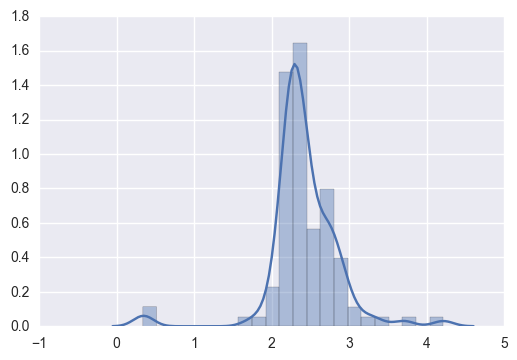

In [25]:
import seaborn as sns
sns.distplot(deltas)

In [15]:
compare = pd.merge(hist, res.results(), on=['Premise', 'Year'])
compare['HistVar'] = abs((
    compare.CapacityTagValue - compare.ICap
    )/compare.CapacityTagValue * 100.0)
compare['MeterType'] = s.meter_type

In [16]:
compare

,Premise,Year,CapacityTagValue,Count,ICap,RateClass,HistVar,MeterType
0,PE000008345788744080,2014,874.021,5,873.994248,LPLP,0.003061,INT
1,PE000008345788744080,2015,814.546,4,NaN,LPLP,NaN,INT


In [ ]:
p = PSEGInterval(conn, ) 

In [ ]:
import pandas as pd
df = pd.DataFrame({'M':{'a':1}})

In [ ]:
df.empty

# Updating Timestamp

In [6]:
from icap.correlation.correlation import Premise

In [7]:
prem = df.ix[40,'PremiseId']
yr = '2015'; utility = 'PPL'

In [8]:
p = Premise(conn=conn, year=yr, utility=utility, premise=prem)

In [9]:
# load the records
p.initialize()

In [10]:
p.history_[p.history_['CoincidentPeak'] == 1]

,UsageDate,PremUsage,PremNormalizedUsage,PeakDay,CoincidentPeak
1336,Mon Jul 20 2015 17:00:00,4.723,0.327986,False,1
1528,Tue Jul 28 2015 17:00:00,4.723,0.327986,False,1
1552,Wed Jul 29 2015 17:00:00,4.666,0.324028,False,1
2006,Mon Aug 17 2015 15:00:00,5.011,0.347986,False,1
2416,Thu Sep 03 2015 17:00:00,7.027,0.487986,False,1


In [23]:
type(p.history_.ix[0]['UsageDate'])

pandas.tslib.Timestamp

In [24]:
cp_query = """
    select
        CPDate,
        cast(HourEnding as int) as HourEnding
    from [CoincidentPeak]
    where
        UtilityId = '{utility}'"""

cp_query = cp_query.format(utility=utility)
cp_df = pd.read_sql(cp_query, conn)
cp_df['CPDate'] = pd.to_datetime(cp_df['CPDate']) 

In [37]:
p.history_['CoincidentPeak'] = 0
p.history_.set_value(cp_dates, 'CoincidentPeak', 1);


In [38]:
p.history_[p.history_['CoincidentPeak'] == 1]

,UsageDate,HourEnding,PremUsage,PremNormalizedUsage,PeakDay,CoincidentPeak
1336,2015-07-20,17.0,4.723,0.327986,False,1
1528,2015-07-28,17.0,4.723,0.327986,False,1
1552,2015-07-29,17.0,4.666,0.324028,False,1
2006,2015-08-17,15.0,5.011,0.347986,False,1
2416,2015-09-03,17.0,7.027,0.487986,False,1


In [34]:
cp_dates = p.history_.reset_index().merge(cp_df,
    how='inner',
    left_on=['UsageDate', 'HourEnding'],
    right_on=['CPDate', 'HourEnding']).set_index('index').index

Int64Index([1336, 1528, 1552, 2006, 2416], dtype='int64', name='index')

In [16]:
df['CoincidentPeak'] = 0
df.set_value(cp_idx, 'CoincidentPeak', 1)

In [5]:
from icap.correlation.correlation import Correlation

In [8]:
c = Correlation(conn=conn, year=yr, iso='pjm-rto', utility='ppl', premise=prem)

In [10]:
cr = c.analyze()

In [11]:
cr.results()['premise_record']

[{'PeakDay': False,
  'PremNormalizedUsage': 0.08402777777777778,
  'PremUsage': 1.21,
  'UsageDate': 'Tue May 26 2015 01:00:00'},
 {'PeakDay': False,
  'PremNormalizedUsage': 0.06402777777777778,
  'PremUsage': 0.922,
  'UsageDate': 'Tue May 26 2015 02:00:00'},
 {'PeakDay': False,
  'PremNormalizedUsage': 0.0920138888888889,
  'PremUsage': 1.325,
  'UsageDate': 'Tue May 26 2015 03:00:00'},
 {'PeakDay': False,
  'PremNormalizedUsage': 0.1479861111111111,
  'PremUsage': 2.131,
  'UsageDate': 'Tue May 26 2015 04:00:00'},
 {'PeakDay': False,
  'PremNormalizedUsage': 0.1479861111111111,
  'PremUsage': 2.131,
  'UsageDate': 'Tue May 26 2015 05:00:00'},
 {'PeakDay': False,
  'PremNormalizedUsage': 0.2040277777777778,
  'PremUsage': 2.938,
  'UsageDate': 'Tue May 26 2015 06:00:00'},
 {'PeakDay': False,
  'PremNormalizedUsage': 0.18000000000000002,
  'PremUsage': 2.592,
  'UsageDate': 'Tue May 26 2015 07:00:00'},
 {'PeakDay': False,
  'PremNormalizedUsage': 0.18000000000000002,
  'PremUsage': 